<a href="https://colab.research.google.com/github/hyemworks/make-your-firstGAN-with-pytorch/blob/main/ch06_1010_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 06 &nbsp;&nbsp;&nbsp;&nbsp;1010 Pattern**

이미지를 생성하는 것보다 간단한 작업으로 먼저 "1010 패턴"형식의 값을 생성해내는 GAN을 구현해보자!

<br>

**[ 체크할 것 ]**
* GAN 코드가 일반적으로 **어떻게 생겼는지** 확인
* 신경망이 **어떻게 학습되는지** 확인

## 실제 데이터 소스


In [33]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt

import numpy

In [34]:
# function to generate real data

import random

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2)])
  return real_data

generate_real()

tensor([0.9608, 0.0919, 0.8617, 0.1352])

## 판별기 만들기

* 입력 레이어에서 4개의 입력을 받는다.
* 출력 레이어에서 참인 경우 1, 거짓인 경우 0을 출력한다.
* 은닉 레이어에는 세 개의 노드가 사용된다.

In [35]:
class Discriminator(nn.Module):
  
  # Constructor
  def __init__(self):

    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
    self.model = nn.Sequential(
        nn.Linear(4, 3),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
        nn.Sigmoid(),
        nn.Linear(3, 1),    # Linear : ,,
        nn.Sigmoid()
    )

    # Loss Function 설정
    self.loss_function = nn.MSELoss()

    # Optimizer 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
    self.counter = 0
    self.progress = []


  # forward function : 네트워크에 정보 전달
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)



  # train
  def train(self, inputs, targets):
    # inputs  : 신경망에 전달할 입력  
    # targets : 원하는 목표 --> 이를 통해 손실을 계산

    ### 신경망 출력 계산
    outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
    
    ### 손실 계산
    loss = self.loss_function(outputs, targets)
    #  계산 그래프의 마지막 노드는 손실함수!
    #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
    

    ### 훈련 시각화 (모니터링)
    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)


    ### 손실을 사용해 네트워크의 가중치를 업데이트
    # 기울기 초기화
    self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
    # 역전파 실행
    loss.backward()
    # 가중치 갱신
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
  

## 판별기 테스트하기

현재는 아직 생성기를 만들기 전이기 때문에,<br>
판별기가 생성기와 제대로 경쟁하는지 진짜 테스트하기가 어려움.<br>
➡ 판별기가 임의의 데이터에 대하여 **실제 데이터를 구별해낼 정도의 성능을 가졌느냐**를 확인할 수 있음.

In [4]:
def generate_random(size):
  random_data = torch.rand(size)  # 0과 1사이의 size개의 값을 가진 텐서를 반환
  return random_data

이제 제대로 분류하면 보상을 받는 훈련과정으로 판별기를 훈련해보자.

* 1010 패턴 데이터는 진짜이므로 목표출력은 1.0으로
* 임의의 노이즈 데이터는 가짜이므로 목표출력은 0.0으로

In [6]:
D=Discriminator()

for i in range(10000):
  # real data
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # fake data
  D.train(generate_random(4), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000


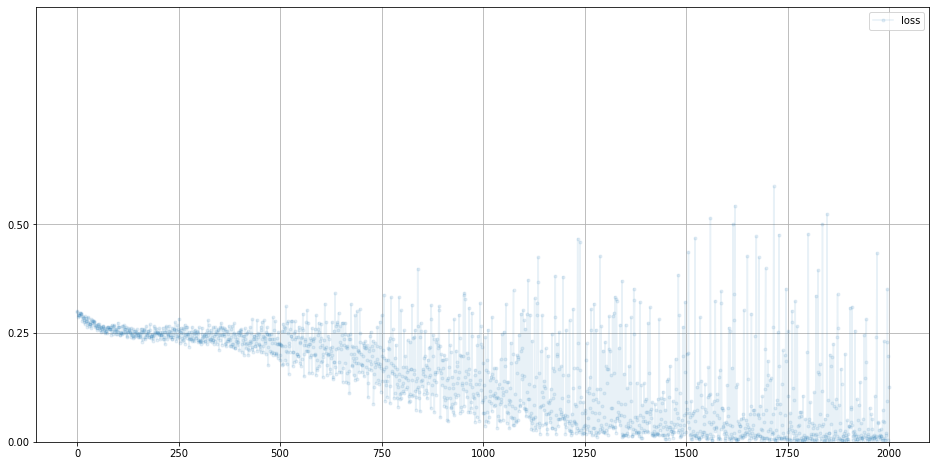

In [7]:
# plot discriminator loss

D.plot_progress()

In [19]:
# manually run discriminator to check it can tell real data from fake

test_real = generate_real()
test_fake = generate_random(4)

print( test_real )
print( D.forward(test_real) )
print( D.forward(test_real).item() )

print()

print( test_fake )
print( D.forward(test_fake) )
print( D.forward(test_fake).item() )

tensor([0.9142, 0.1556, 0.8414, 0.0021])
tensor([0.8239], grad_fn=<SigmoidBackward0>)
0.8239241242408752

tensor([0.5019, 0.9176, 0.3230, 0.2544])
tensor([0.0788], grad_fn=<SigmoidBackward0>)
0.07883457839488983


> 🦋 **TORCH.TENSOR.ITEM**<br>
Returns the value of this tensor as a standard Python number.<br>
This only works for tensors with one element.

## 생성기 만들기

생성기는 단순히 함수가 아니라 **훈련**을 필요로 하는 신경망!

In [40]:
class Generator(nn.Module):


  def __init__(self):
    
    # 파이토치 부모클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )

    # 옵티마이저 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행측정을 위한 변수 초기화
    self.counter = 0
    self.progress = []
    self.image_list = []



  def forward(self, inputs):
    
    # 모델 실행
    return self.model(inputs)



  def train(self, D, inputs, targets):

    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차계산
    loss = D.loss_function(d_output, targets)


    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter %10 == 0):
      self.progress.append(loss.item())
    
    # 매 1000회마다 이미지 저장
    if (self.counter % 1000 == 0):
      self.image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy())


    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


  def plot_images(self):
    # plot images collected during training
    plt.figure(figsize=(16,8))
    plt.imshow(numpy.array(self.image_list).T, interpolation = "None", cmap="Blues")



* 생성기에는 판별기와 달리 <code>self.loss</code>를 정의하는 부분이 없다
* 생성기는 판별기로부터 흘러온 그래디언트 오차를 통해 업데이트가 된다

## 생성기 결과 확인하기

In [24]:
# check the generator output

G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.6407, 0.4598, 0.7788, 0.6116], grad_fn=<SigmoidBackward0>)

## GAN 훈련하기

In [41]:
%%time

# Create Discriminator and Generator

D = Discriminator()
G = Generator()


# Train Discriminator and Generator

for i in range (10000):
  
  # 01. train dicriminator on "real data"
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 02. train discriminator on "fake data"
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
          # use detach() so gradients in G are not calculated

  # 03. train generator
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))


counter =  10000
counter =  20000
CPU times: user 17.6 s, sys: 30.5 ms, total: 17.6 s
Wall time: 17.5 s


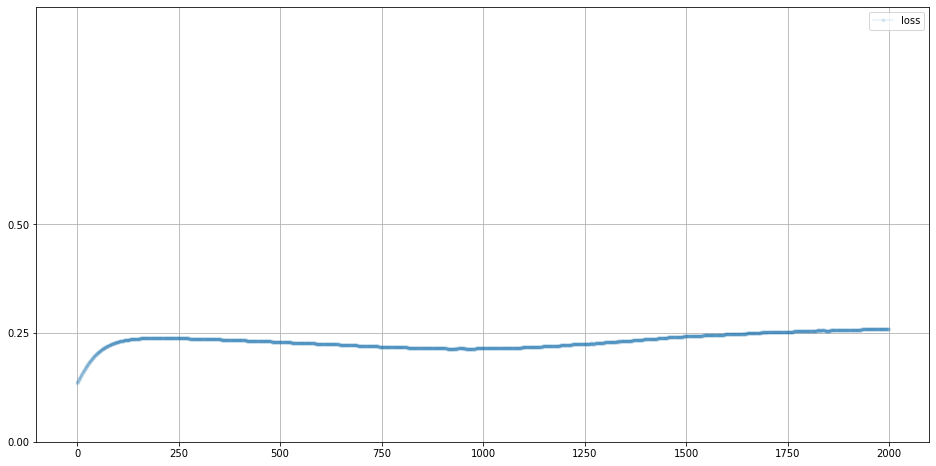

In [42]:
# plot discriminator error

D.plot_progress()

↪ 훈련의 후반부로 갈수록 손실이 0.25로 올라가는 이유 ➡ **생성기가 판별기가 구별하기 쉽지않은 데이터를 만들어내기 시작했음을 의미!**

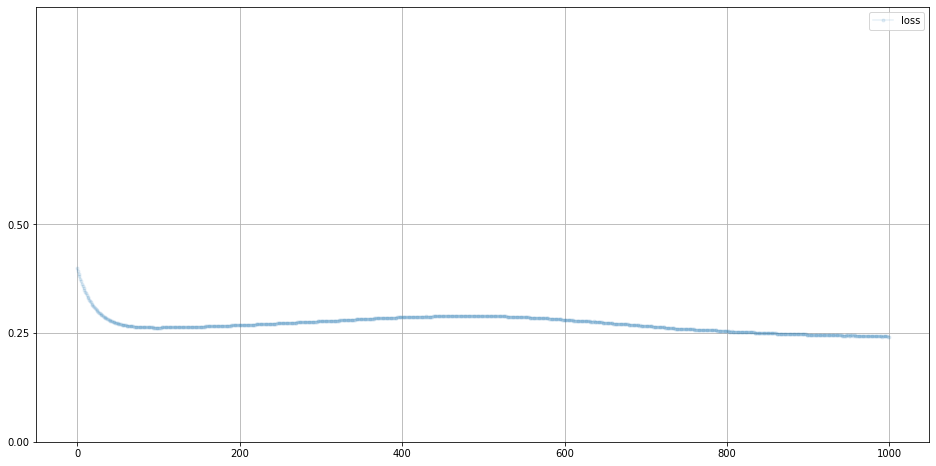

In [43]:
# plot generator error

G.plot_progress()

In [28]:
# manually run generator to see its outputs

G.forward(torch.FloatTensor([0.5]))

tensor([0.9441, 0.0611, 0.9114, 0.0551], grad_fn=<SigmoidBackward0>)

↪ 위 결과를 통해, 생성기가 1010패턴을 생성하도록 잘 훈련되었음을 알 수 있음

<br>
<br>
<br>


##### **[+]**

추가적인 실험으로, 1010 패턴이 어떤 식으로 훈련을 거치며 변화하는지 시각화해보자.



```
# save image every 1000 times

if (i % 1000 == 0):
  image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy())
```



↪ 생성기의 출력 텐서에서 넘파이 행렬로 값을 추출하기 위해 **numpy()** 함수 호출 전 **detach()** 함수를 통해 계산 그래프로부터 값을 떼어내는 과정이 필요

(해당부분을 generator 클래스 내부에 삽입)



```
# plot images collected during training

plt.figure(figsize=(16,8))
plt.imshow(numpy.array(image_list).T, interpolation = "None", cmap="Blues")
```

(해당부분 또한 삽입)


In [51]:
G.image_list

[array([0.5402625 , 0.541809  , 0.60905427, 0.345053  ], dtype=float32),
 array([0.5442577 , 0.5329381 , 0.6272503 , 0.33223814], dtype=float32),
 array([0.55840456, 0.5115966 , 0.6599743 , 0.30899537], dtype=float32),
 array([0.5910023 , 0.46404243, 0.7092    , 0.27215725], dtype=float32),
 array([0.64892775, 0.37652406, 0.76884204, 0.22302853], dtype=float32),
 array([0.7249465 , 0.26408243, 0.82489216, 0.17134632], dtype=float32),
 array([0.79657507, 0.17227837, 0.867427  , 0.12882629], dtype=float32),
 array([0.8493943 , 0.11660812, 0.89648634, 0.09913027], dtype=float32),
 array([0.88474005, 0.08497468, 0.91606593, 0.07939512], dtype=float32),
 array([0.9081745 , 0.06627982, 0.92952776, 0.0661606 ], dtype=float32)]

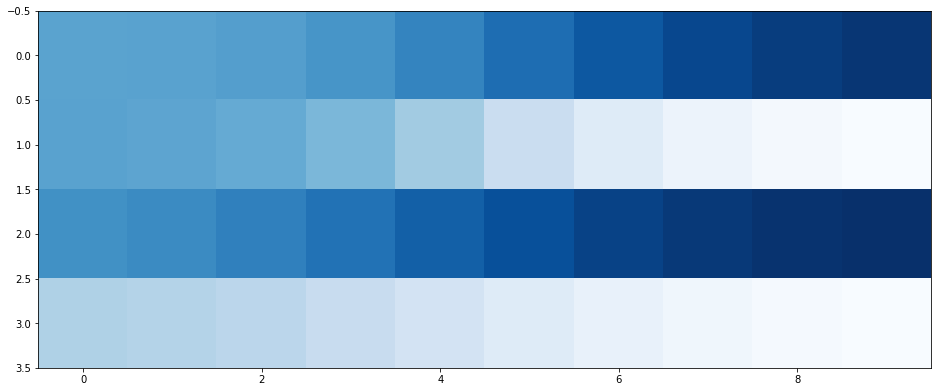

In [45]:
# plot images collected during training

G.plot_images()

---

## **Summary**
> 🦋 GAN 훈련법<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp; (1) 실제 데이터셋 미리 살펴보기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (2) 판별기가 적어도 임의의 노이즈와 실제 데이터를 구별하도록 학습할 수 있을 성능은 지니는 지 확인하기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (3) 훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어내는지 확인하기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (4) 손실이 어떻게 변하는지 **시각화**하기
<br>
<br>

> * 잘 훈련된 GAN은 생성된 가짜 이미지와 실제 이미지를 잘 구별하지 못하는 상태<br>
즉, 출력은 0.5로서 0.0과 1.0의 중간에 해당하는 값.<br>
↪ 평균제곱오차의 이상적인 값은 0.25
* 생성기와 판별기를 각각 따로 시각화하는 것은 유용함.
* 생성기의 손실은 생성된 데이터로부터 발생한 판별기의 손실임.

---